In [2]:
import pandas as pd
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



# === Load Data ===
file_path = "/Users/jasonraiti/Documents/GitHub/Open_Weather/Open_Weather/Open_Meteo/Scalable_30day/June11/precipitation_data.csv"
df_raw = pd.read_csv(file_path)


In [3]:
df = df_raw.copy()

# === Strip whitespace and preview columns ===
df.columns = df.columns.str.strip()

# === Keep original values for inspection ===
df['precip_mm_raw'] = df['precip_mm']

# === Coerce precip_mm to numeric, catching problems ===
df['precip_mm'] = pd.to_numeric(df['precip_mm'], errors='coerce')
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# === Ensure coordinates are numeric for validation ===
df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')

# === Identify Problems ===
problem_precip = df[df['precip_mm'].isna() & df['precip_mm_raw'].notna()]
negative_precip = df[df['precip_mm'] < 0]
missing_dates = df[df['date'].isna()]
weird_coords = df[(df['latitude'].abs() > 90) | (df['longitude'].abs() > 180)]

# === Print Suspicious Rows ===
print("\n⚠️ Non-numeric or malformed 'precip_mm' values:")
print(problem_precip[['taxa_name', 'date', 'precip_mm_raw']].head(10))

print("\n⚠️ Negative 'precip_mm' values:")
print(negative_precip[['taxa_name', 'date', 'precip_mm']].head(10))

print("\n⚠️ Malformed or missing 'date' values:")
print(missing_dates[['taxa_name', 'date', 'precip_mm']].head(10))

print("\n⚠️ Suspicious latitude/longitude values:")
print(weird_coords[['taxa_name', 'latitude', 'longitude']].head(10))

# === Optional: Export all problematic rows for review ===
problem_rows = pd.concat([
    problem_precip,
    negative_precip,
    missing_dates,
    weird_coords
]).drop_duplicates()

problem_rows.to_csv("suspicious_entries.csv", index=False)


⚠️ Non-numeric or malformed 'precip_mm' values:
Empty DataFrame
Columns: [taxa_name, date, precip_mm_raw]
Index: []

⚠️ Negative 'precip_mm' values:
Empty DataFrame
Columns: [taxa_name, date, precip_mm]
Index: []

⚠️ Malformed or missing 'date' values:
Empty DataFrame
Columns: [taxa_name, date, precip_mm]
Index: []

⚠️ Suspicious latitude/longitude values:
Empty DataFrame
Columns: [taxa_name, latitude, longitude]
Index: []


⚠️ 0 invalid precipitation values found and set to NaN


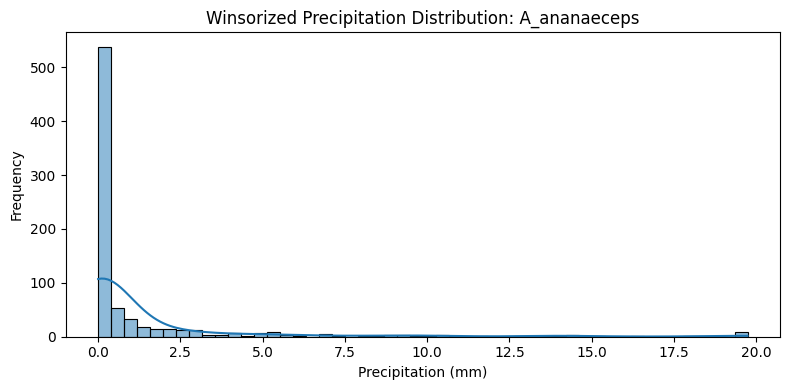

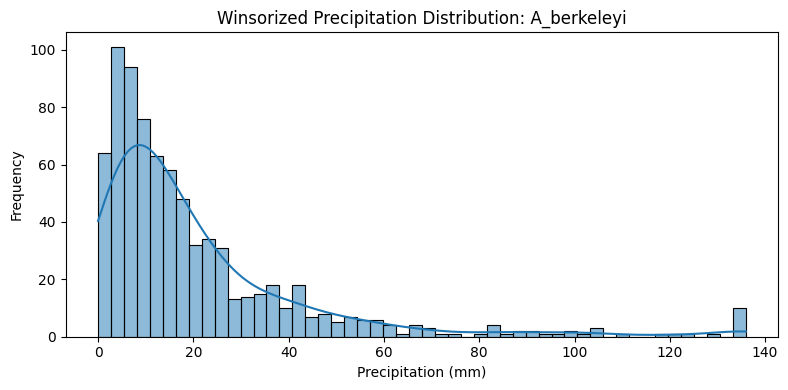

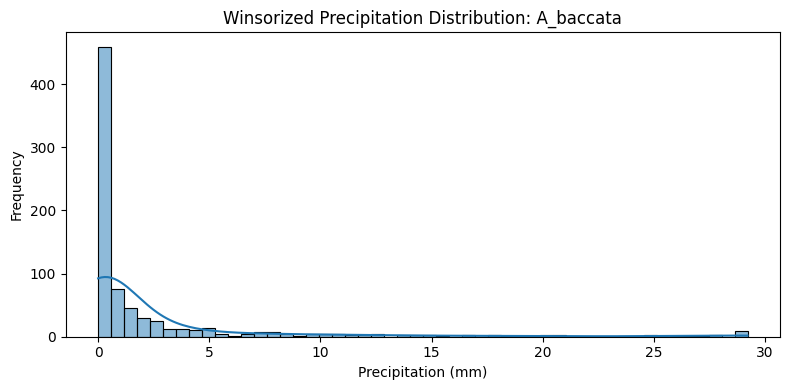

In [4]:

# === Clean Column Names ===
df.columns = df.columns.str.strip()

# === Convert `precip_mm` to numeric (force coercion) ===
df['precip_mm'] = pd.to_numeric(df['precip_mm'], errors='coerce')

# Check how many values were coerced to NaN
num_invalid = df['precip_mm'].isna().sum()
print(f"⚠️ {num_invalid} invalid precipitation values found and set to NaN")

# === Convert `date` to datetime ===
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# === Winsorize Precipitation Per Taxa (99th percentiles) ===
def upper_winsorize_series(x, upper=0.99):
    q_high = x.quantile(upper)
    return x.clip(upper=q_high)

df['precip_mm_winsor'] = df.groupby('taxa_name')['precip_mm'].transform(upper_winsorize_series)

# === Summary Statistics by Taxa ===
summary_stats = df.groupby("taxa_name")["precip_mm_winsor"].agg(
    count="count",
    mean="mean",
    std="std",
    max="max",
    min="min",
    total="sum",
    zero_days=lambda x: (x == 0).sum()
).reset_index()

summary_stats.to_csv("taxa_summary_statistics_winsorized.csv", index=False)

# === Z-Score Based Outlier Detection (Winsorized) ===
df['zscore'] = df.groupby('taxa_name')['precip_mm_winsor'].transform(zscore)
df['outlier'] = df['zscore'].abs() > 3

# === Step: Flag Invalid Values ===
df['negative_precip'] = df['precip_mm'] < 0
df['missing_date'] = df['date'].isna()

# === Save Flagged Dataset ===
df.to_csv("precipitation_data_flagged_winsorized.csv", index=False)

# === Quick Visual Check ===
sample_taxa = df['taxa_name'].dropna().unique()[:3]

for taxa in sample_taxa:
    subset = df[df['taxa_name'] == taxa]
    plt.figure(figsize=(8, 4))
    sns.histplot(subset['precip_mm_winsor'].dropna(), bins=50, kde=True)
    plt.title(f"Winsorized Precipitation Distribution: {taxa}")
    plt.xlabel("Precipitation (mm)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()
